In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.patches import Path, PathPatch
import pandas as pd
from shapely.geometry import Point, shape, Polygon
from shapely.ops import unary_union, cascaded_union
from geopandas.tools import sjoin
import geopandas as gpd
from netCDF4 import Dataset
from cartopy import crs as ccrs
from cartopy.io.shapereader import Reader
from sklearn.metrics import mean_squared_error
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

C:\Users\x12la\AppData\Local\Temp\ipykernel_23532\585246329.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  from geopandas.tools import sjoin


In [2]:
## Upload Aconc shapefiles
base = gpd.read_file('AnnualAvg_75WH_FromAllTimeSteps.shp')
base = base.to_crs('EPSG:4326')

act = gpd.read_file('AnnualAvg_ACT_FromAllTimeSteps.shp')
act = act.to_crs('EPSG:4326')

mhdv = gpd.read_file('AnnualAvg_eMHDV_ACT_FromAllTimeSteps.shp')
mhdv = mhdv.to_crs('EPSG:4326')

In [3]:
## Upload Aconc shapefiles
base_mda8o3 = gpd.read_file('AnnualAvgMDA8O3_75WH_FromAllTimeSteps.shp')
base_mda8o3 = base_mda8o3.to_crs('EPSG:4326')

act_mda8o3 = gpd.read_file('AnnualAvgMDA8O3_ACT_FromAllTimeSteps.shp')
act_mda8o3 = act_mda8o3.to_crs('EPSG:4326')

mhdv_mda8o3 = gpd.read_file('AnnualAvgMDA8O3_eMHDV_ACT_FromAllTimeSteps.shp')
mhdv_mda8o3 = mhdv_mda8o3.to_crs('EPSG:4326')

In [4]:
#CMAP 7 counties surrounding Chicago/Cook County
cmap_cty = gpd.read_file('C:/Users/x12la/Desktop/Scripts/CMAP_cty.shp')
cmap_cty = cmap_cty.to_crs('EPSG:4326')

#primary roads
primary_roads = gpd.read_file('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp')
primary_roads = primary_roads.to_crs('EPSG:4326')

In [5]:
#Clip geopandas files to CMAP
cmap_roads = gpd.clip(primary_roads, cmap_cty.to_crs('EPSG:4326'))
cmap_base = gpd.clip(base, cmap_cty.to_crs('EPSG:4326'))
cmap_act = gpd.clip(act, cmap_cty.to_crs('EPSG:4326'))
cmap_mhdv = gpd.clip(mhdv, cmap_cty.to_crs('EPSG:4326'))

In [6]:
#Clip geopandas files to CMAP
cmap_base_mda8o3 = gpd.clip(base_mda8o3, cmap_cty.to_crs('EPSG:4326'))
cmap_act_mda8o3 = gpd.clip(act_mda8o3, cmap_cty.to_crs('EPSG:4326'))
cmap_mhdv_mda8o3 = gpd.clip(mhdv_mda8o3, cmap_cty.to_crs('EPSG:4326'))

In [7]:
# ---------------------------------------------------------------------
#d02 = Dataset('C:/Users/x12la/lat_lon_chicago_d02.nc')
d03 = Dataset('C:/Users/x12la/Desktop/latlon_ChicagoLADCO_d03.nc')
cmaq_lon,cmaq_lat = np.array(d03['lon']),np.array(d03['lat'])
cmaq_llat,cmaq_ulat,cmaq_llon,cmaq_ulon=cmaq_lat.min(), cmaq_lat.max(), cmaq_lon.min(), cmaq_lon.max()

<h1> Plot study domain 

(40.0, 44.5)

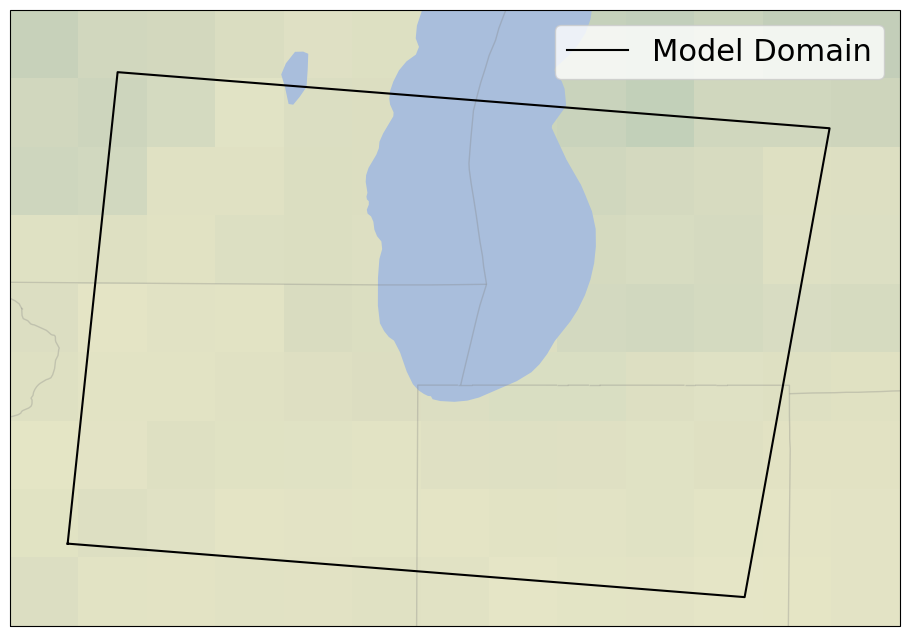

In [8]:
#lat2,lon2 = d02['LAT'][0][0].data,d02['LON'][0][0].data
lat3,lon3 = np.array(d03['lat']),np.array(d03['lon'])

#lats2 = lat2[0].tolist()+lat2.T[0].tolist()+lat2[-1].tolist()+lat2.T[-1].tolist()
#lons2 = lon2[0].tolist()+lon2.T[0].tolist()+lon2[-1].tolist()+lon2.T[-1].tolist()

lats3 = lat3[0].tolist()+lat3.T[0].tolist()+lat3[-1].tolist()+lat3.T[-1].tolist()
lons3 = lon3[0].tolist()+lon3.T[0].tolist()+lon3[-1].tolist()+lon3.T[-1].tolist()

outlinelon = np.array([[lon3[0].tolist()[0]]+[lon3.T[0].tolist()[-1]]+[lon3[-1].tolist()[-1]]+[lon3.T[-1].tolist()[0]]+[lon3[0][0]]])[0]
outlinelat = np.array([[lat3[0].tolist()[0]]+[lat3.T[0].tolist()[-1]]+[lat3[-1].tolist()[-1]]+[lat3.T[-1].tolist()[0]]+[lat3[0][0]]])[0]

# ---------------------------------------------------------------------
# create fig obj
crs_new = ccrs.PlateCarree()# get shape outside
#fig,axs = plt.subplots(1,2,subplot_kw={'projection': crs_new},figsize=(9,5))
fig= plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

resol = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='face',facecolor=cfeature.COLORS['land'])
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m', facecolor=cfeature.COLORS['water'])
states = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',edgecolor='gray',facecolor='none',scale='10m',alpha = 0.3)
borders = cfeature.NaturalEarthFeature(scale='50m',category='cultural',name='admin_0_countries',edgecolor='gray',facecolor='lightgray',alpha=0.3)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', scale=resol, edgecolor='none', facecolor=cfeature.COLORS['water'])

#ax.add_feature(land)
ax.stock_img()
ax.add_feature(lakes)
ax.add_feature(borders)
ax.add_feature(states)
ax.add_feature(ocean)

ax.plot(outlinelon,outlinelat, c='k', label='Model Domain')

#chi.boundary.plot(ax=ax, color='k', alpha=.5)
# cmap_roads.plot(ax=ax, color='grey', alpha=.05)

plt.legend(fontsize=22)
plt.xlim(-90.5, -84)
plt.ylim(40, 44.5)
#ax.set_title('WRF-CMAQ Model Domain')

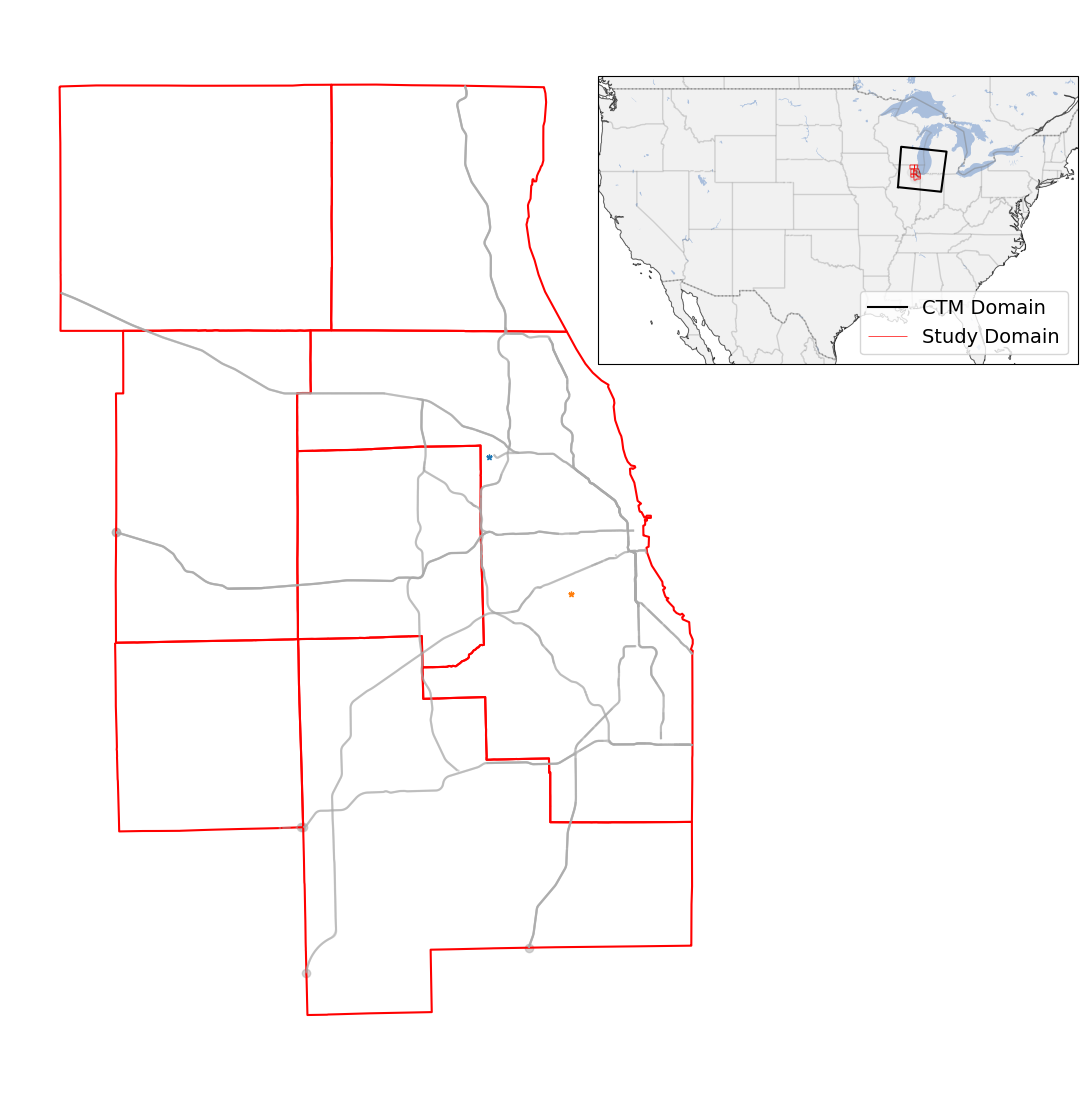

In [9]:
# Create the figure and axes for the main plot (zoomed-in view of cmap_cty.boundary)
fig = plt.figure(figsize=(12, 14))
main_ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the zoomed-in view of cmap_cty.boundary
cmap_cty.boundary.plot(ax=main_ax, color='red', linewidth=1.5)
cmap_roads.plot(ax=main_ax, color='darkgrey', alpha=0.5)
plt.scatter( -87.904724, 41.978611, marker='*', s=15)
plt.scatter( -87.7522, 41.7868, marker='*', s=15)
main_ax.set_extent([-88.8, -87.4, 41.1, 42.6], crs=ccrs.PlateCarree())
main_ax.add_feature(cfeature.LAND, facecolor='white')
main_ax.set_axis_off()
main_ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
main_ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')

# Create a subplot for the US map
inset_ax = fig.add_axes([0.69, 0.53, 0.4, 0.4], projection=ccrs.PlateCarree())
inset_ax.set_extent([-124.5, -69.5, 25.5, 50.1], crs=ccrs.PlateCarree())
inset_ax.add_feature(cfeature.LAND, facecolor='white')
inset_ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
inset_ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
inset_ax.plot(outlinelon, outlinelat, c='k', label='CTM Domain')
cmap_cty.boundary.plot(ax=inset_ax, color='red', alpha=1, linewidth=.5, label='Study Domain')

cmap_roads.plot(ax=inset_ax, color='grey', alpha=0.05)
inset_ax.add_feature(lakes)
inset_ax.add_feature(borders)
inset_ax.add_feature(states)

# Add a legend to the inset plot
inset_ax.legend(loc='lower right', fontsize=14)

# Save the figure
plt.savefig('Map_CMAP_Domain_Remade.tiff', dpi=300, format='tiff')
plt.show()


<h1> NO2 Analysis 

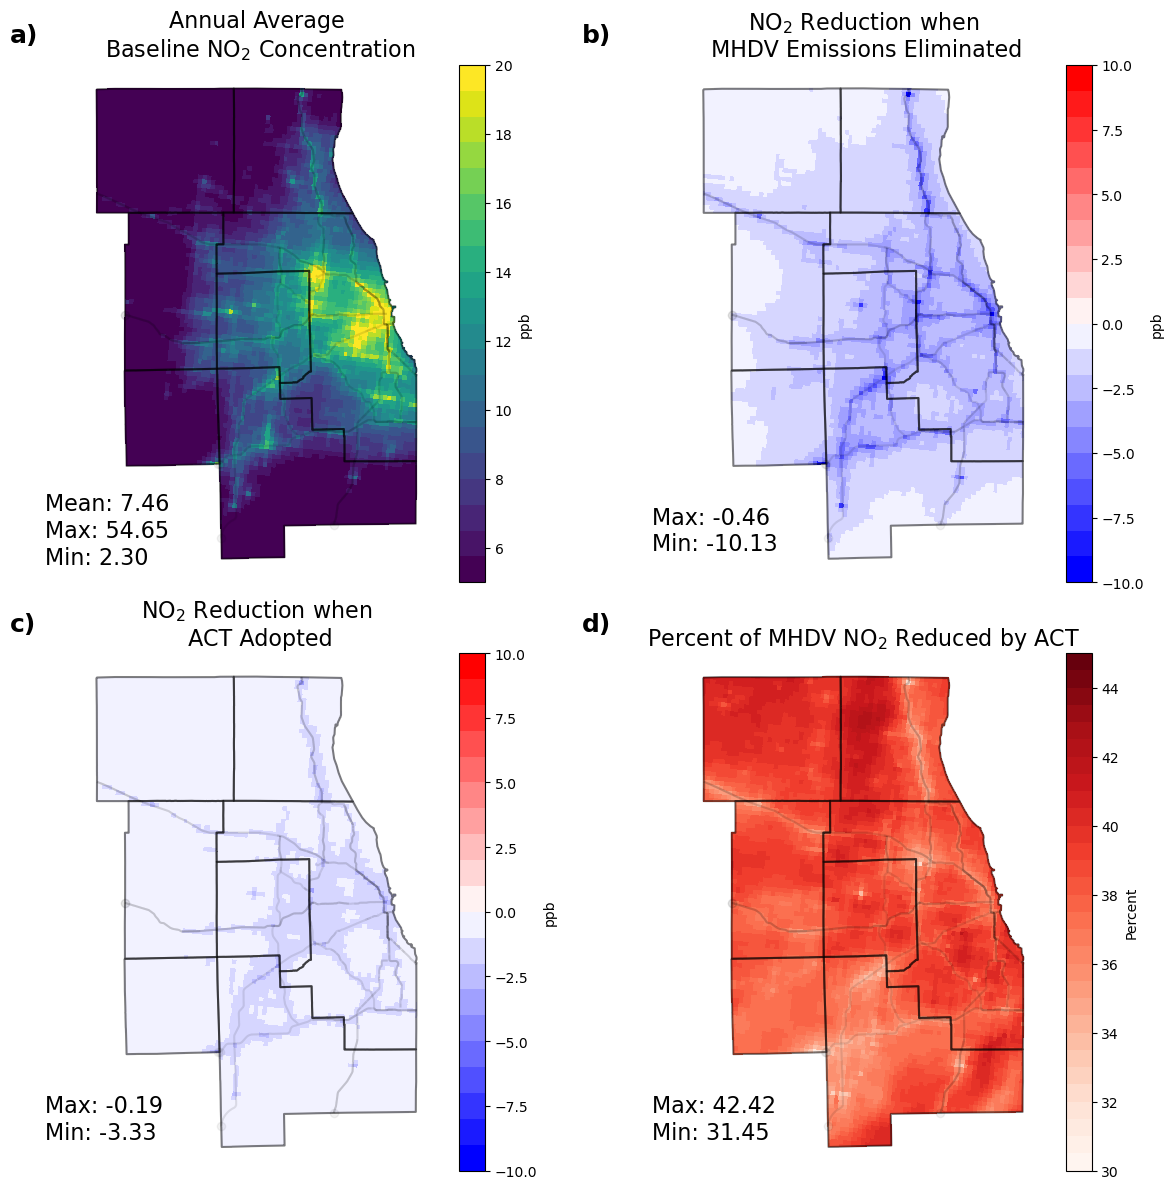

In [10]:
cmap_base['NO2_act_diff'] =  (cmap_act['NO2']-cmap_base['NO2'])
cmap_base['NO2_mhdv_diff'] =  (cmap_mhdv['NO2']-cmap_base['NO2'])

# Calculate the % difference between cmap_act and cmap_mhdv NO2
cmap_base['NO2_act_mhdv_diff'] = ((cmap_act['NO2'] - cmap_base['NO2']) / (cmap_mhdv['NO2'] - cmap_base['NO2'])) * 100
#cmap_base['NO2_act_mhdv_diff'] = ((cmap_base['NO2'] - cmap_act['NO2']) / (cmap_base['NO2'] - cmap_mhdv['NO2'])) * 100

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# First Figure (Panel a)
axs[0, 0].set_title("Annual Average\n Baseline NO$_2$ Concentration", fontsize=16)
cmap_base.plot('NO2', ax=axs[0, 0], vmin=5, vmax=20, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "ppb", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[0, 0], color='k', alpha=.5)
cmap_roads.plot(ax=axs[0, 0], color='k', alpha=.05)
axs[0, 0].set_axis_off()
axs[0, 0].text(-0.2, 1.08, "a)", transform=axs[0, 0].transAxes, fontsize=18, fontweight='bold', va='top')
axs[0, 0].text(-0.1, 0.1, f"Mean: {cmap_base['NO2'].mean():.2f}\nMax: {cmap_base['NO2'].max():.2f}\nMin: {cmap_base['NO2'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[0, 0].transAxes)

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.bwr(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Second Figure (Panel b)
axs[0, 1].set_title("NO$_2$ Reduction when\n MHDV Emissions Eliminated", fontsize=16)
cmap_base.plot('NO2_mhdv_diff', ax=axs[0, 1], vmin=-10, vmax=10, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "ppb", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[0, 1], color='k', alpha=.5)
cmap_roads.plot(ax=axs[0, 1], color='k', alpha=.05)
axs[0, 1].set_axis_off()
axs[0, 1].text(-0.3, 1.08, "b)", transform=axs[0, 1].transAxes, fontsize=18, fontweight='bold', va='top')
axs[0, 1].text(-0.1, 0.1, f"Max: {cmap_base['NO2_mhdv_diff'].max():.2f}\nMin: {cmap_base['NO2_mhdv_diff'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[0, 1].transAxes)

# Third Figure (Panel c)
axs[1, 0].set_title("NO$_2$ Reduction when\n ACT Adopted", fontsize=16)
cmap_base.plot('NO2_act_diff', ax=axs[1, 0], vmin=-10, vmax=10, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "ppb", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[1, 0], color='k', alpha=.5)
cmap_roads.plot(ax=axs[1, 0], color='k', alpha=.05)
axs[1, 0].set_axis_off()
axs[1, 0].text(-0.2, 1.08, "c)", transform=axs[1, 0].transAxes, fontsize=18, fontweight='bold', va='top')
axs[1, 0].text(-0.1, 0.1, f"Max: {cmap_base['NO2_act_diff'].max():.2f}\nMin: {cmap_base['NO2_act_diff'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[1, 0].transAxes)

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.Reds(np.linspace(0, 1, 30))  # Get 100 evenly spaced colors from reds colormap
cmap_discrete = ListedColormap(viridis_colors)

# Fourth Figure (Panel d)
axs[1, 1].set_title("Percent of MHDV NO$_2$ Reduced by ACT", fontsize=16)
cmap_base.plot('NO2_act_mhdv_diff', ax=axs[1, 1], vmin=30, vmax=45, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "Percent", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[1, 1], color='k', alpha=.5)
cmap_roads.plot(ax=axs[1, 1], color='k', alpha=.05)
axs[1, 1].set_axis_off()
axs[1, 1].text(-0.3, 1.08, "d)", transform=axs[1, 1].transAxes, fontsize=18, fontweight='bold', va='top')
axs[1, 1].text(-0.1, 0.1, f"Max: {cmap_base['NO2_act_mhdv_diff'].max():.2f}\nMin: {cmap_base['NO2_act_mhdv_diff'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[1, 1].transAxes)

plt.tight_layout()
plt.savefig('NO2_Diff_ACT.tiff', dpi=300, format='tiff')
plt.show()

In [11]:
print('diff total NO2 ACT: ', (cmap_act['NO2'].sum()-cmap_base['NO2'].sum()))
print('diff total NO2 MHDV: ', (cmap_mhdv['NO2'].sum()-cmap_base['NO2'].sum()))

print('%diff total NO2 ACT: ', ((cmap_act['NO2'].sum()-cmap_base['NO2'].sum())/cmap_base['NO2'].sum())*100)
print('%diff total NO2 MHDV: ', ((cmap_mhdv['NO2'].sum()-cmap_base['NO2'].sum())/cmap_base['NO2'].sum())*100)

print('diff mean NO2 ACT: ', (cmap_act['NO2'].mean()-cmap_base['NO2'].mean()))
print('diff mean NO2 MHDV: ', (cmap_mhdv['NO2'].mean()-cmap_base['NO2'].mean()))

print('diff mean NO2 ACT: ', ((cmap_act['NO2'].mean()-cmap_base['NO2'].mean())/cmap_base['NO2'].mean())*100)
print('% diff mean NO2 MHDV: ', ((cmap_mhdv['NO2'].mean()-cmap_base['NO2'].mean())/cmap_base['NO2'].mean())*100)

diff total NO2 ACT:  -4231.88077044487
diff total NO2 MHDV:  -11143.698343634605
%diff total NO2 ACT:  -9.35051187184889
%diff total NO2 MHDV:  -24.622452595115153
diff mean NO2 ACT:  -0.6971796985905883
diff mean NO2 MHDV:  -1.835864636513115
diff mean NO2 ACT:  -9.350511871848893
% diff mean NO2 MHDV:  -24.622452595115156


<h1> MDA8 O3 Analysis 

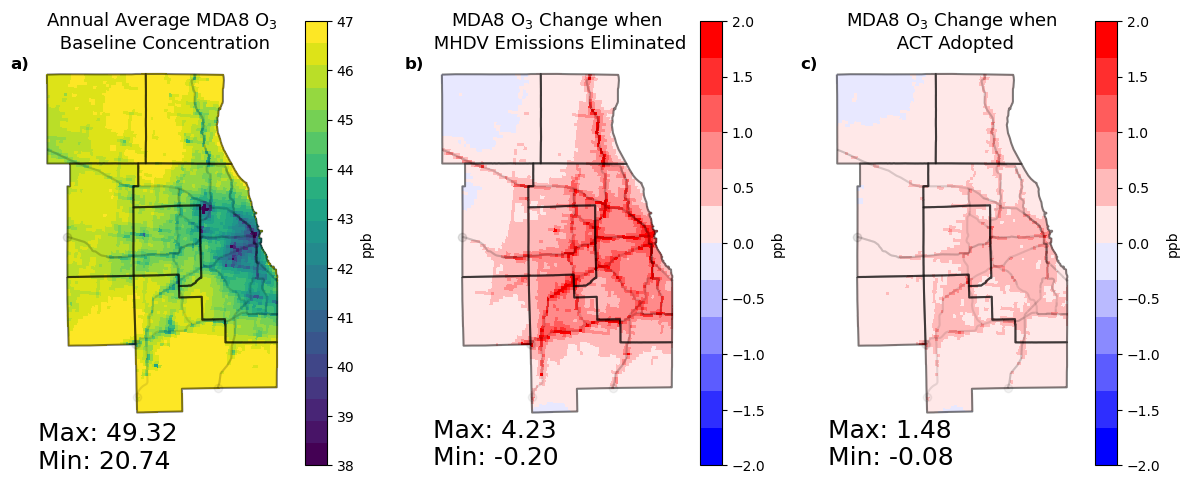

In [13]:
cmap_base_mda8o3['O3_act_diff'] =  cmap_act_mda8o3['O3']-cmap_base_mda8o3['O3']
cmap_base_mda8o3['O3_mhdv_diff'] =  cmap_mhdv_mda8o3['O3']-cmap_base_mda8o3['O3']
# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 5))


# Create a discrete colormap base_mda8o3d on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# First Figure
axs[0].set_title("Annual Average MDA8 O$_3$\n Baseline Concentration",fontsize=13)
cmap_base_mda8o3.plot('O3', ax=axs[0], vmin=38,vmax=47, legend=True, cmap=cmap_discrete,antialiased=False,
               legend_kwds={"label": "ppb", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[0], color='k', alpha=.5)
cmap_roads.plot(ax=axs[0], color='k', alpha=.05)
axs[0].set_axis_off()
axs[0].text(-0.1, 1.0, "a)", transform=axs[0].transAxes, fontsize=12, fontweight='bold', va='top')
axs[0].text(0.01, -0.05, f"Max: {cmap_base_mda8o3['O3'].max():.2f}\nMin: {cmap_base_mda8o3['O3'].min():.2f}",
            horizontalalignment='left', fontsize=18, verticalalignment='center', transform=axs[0].transAxes)

# Create a discrete colormap base_mda8o3d on Viridis
viridis_colors = plt.cm.bwr(np.linspace(0, 1, 12))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Second Figure
axs[2].set_title("MDA8 O$_3$ Change when\n ACT Adopted",fontsize=13)
cmap_base_mda8o3.plot('O3_act_diff', ax=axs[2], vmin=-2, vmax=2, legend=True, cmap=cmap_discrete,
               antialiased=False,legend_kwds={"label": "ppb", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[2], color='k', alpha=.5)
cmap_roads.plot(ax=axs[2], color='k', alpha=.05)
axs[2].set_axis_off()
axs[2].text(-0.1, 1.0, "c)", transform=axs[2].transAxes, fontsize=12, fontweight='bold', va='top')
axs[2].text(0.01, -0.04, f"Max: {cmap_base_mda8o3['O3_act_diff'].max():.2f}\nMin: {cmap_base_mda8o3['O3_act_diff'].min():.2f}",
            horizontalalignment='left', fontsize=18, verticalalignment='center', transform=axs[2].transAxes)

# Third Figure
axs[1].set_title("MDA8 O$_3$ Change when\n MHDV Emissions Eliminated",fontsize=13)
cmap_base_mda8o3.plot('O3_mhdv_diff', ax=axs[1], vmin=-2, vmax=2, legend=True, cmap=cmap_discrete,
               antialiased=False,legend_kwds={"label": "ppb", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[1], color='k', alpha=.5)
cmap_roads.plot(ax=axs[1], color='k', alpha=.05)
axs[1].set_axis_off()
axs[1].text(-0.1, 1.0, "b)", transform=axs[1].transAxes, fontsize=12, fontweight='bold', va='top')
axs[1].text(0.01, -0.04, f"Max: {cmap_base_mda8o3['O3_mhdv_diff'].max():.2f}\nMin: {cmap_base_mda8o3['O3_mhdv_diff'].min():.2f}",
            horizontalalignment='left', fontsize=18, verticalalignment='center', transform=axs[1].transAxes)

plt.tight_layout()
plt.savefig('mda83_diff_ACT.tiff', dpi=300, format='tiff')
plt.show()

<h1> VOC-NOx Ratio Analysis

C:\Users\x12la\AppData\Local\Temp\ipykernel_23532\2589429199.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


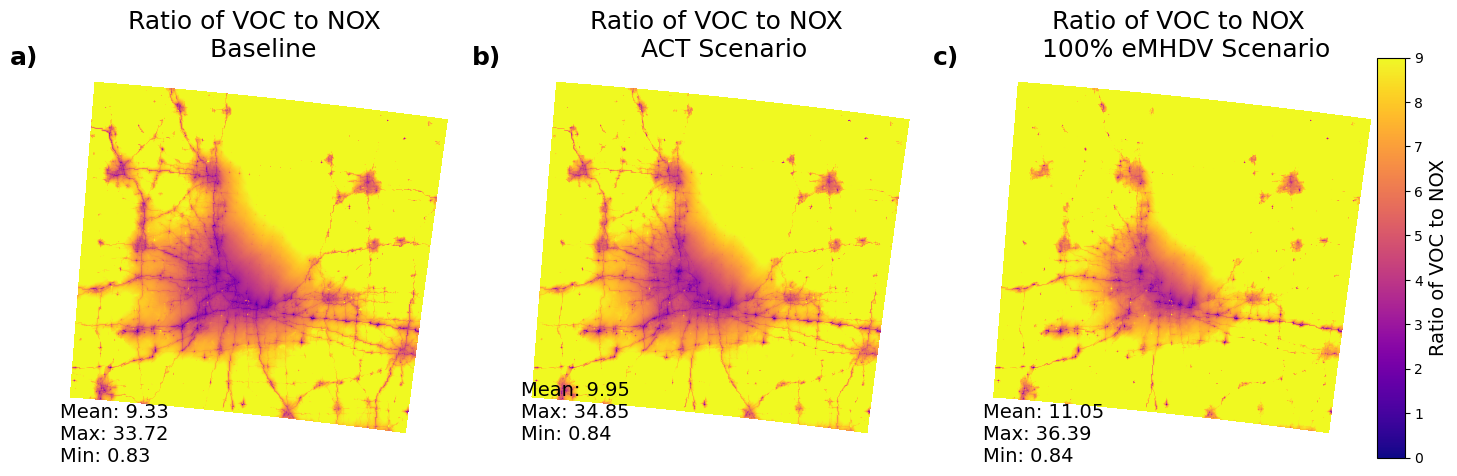

In [14]:
# Calculate the ratio of VOC to NOX
base['baseline_ratio'] = base['VOC'] / base['NOX']
act['act_ratio'] = act['VOC'] / act['NOX']
mhdv['mhdv_ratio'] = mhdv['VOC'] / mhdv['NOX']

# Create subplots with 1 row and 3 columns, with larger figure size
fig, axs = plt.subplots(1, 3, figsize=(14, 8))

# Plot base['VOC'] / base['NOX']
base_plot = base.plot('baseline_ratio', ax=axs[0], legend=False, vmin=0, vmax=9, cmap='plasma', antialiased=False)
axs[0].set_title("Ratio of VOC to NOX \n Baseline", fontsize=18)
axs[0].set_axis_off()
axs[0].text(-0.1, 1.05, "a)", transform=axs[0].transAxes, fontsize=18, fontweight='bold', va='top')
axs[0].text(0.02, -0.04, f"Mean: {base['baseline_ratio'].mean():.2f}\nMax: {base['baseline_ratio'].max():.2f}\nMin: {base['baseline_ratio'].min():.2f}",
            fontsize=14, transform=axs[0].transAxes, va='bottom', ha='left')

# Plot act['VOC'] / act['NOX']
act_plot = act.plot('act_ratio', ax=axs[1], legend=False, vmin=0, vmax=9, cmap='plasma', antialiased=False)
axs[1].set_title("Ratio of VOC to NOX \n ACT Scenario", fontsize=18)
axs[1].set_axis_off()
axs[1].text(-0.1, 1.05, "b)", transform=axs[1].transAxes, fontsize=18, fontweight='bold', va='top')
axs[1].text(0.02, -0.04, f"Mean: {act['act_ratio'].mean():.2f}\nMax: {act['act_ratio'].max():.2f}\nMin: {act['act_ratio'].min():.2f}\n",
            fontsize=14, transform=axs[1].transAxes, va='bottom', ha='left')

# Plot mhdv['VOC'] / mhdv['NOX']
mhdv_plot = mhdv.plot('mhdv_ratio', ax=axs[2], legend=False, vmin=0, vmax=9, cmap='plasma', antialiased=False)
axs[2].set_title("Ratio of VOC to NOX \n 100% eMHDV Scenario", fontsize=18)
axs[2].set_axis_off()
axs[2].text(-0.1, 1.05, "c)", transform=axs[2].transAxes, fontsize=18, fontweight='bold', va='top')
axs[2].text(0.02, -0.04, f"Mean: {mhdv['mhdv_ratio'].mean():.2f}\nMax: {mhdv['mhdv_ratio'].max():.2f}\nMin: {mhdv['mhdv_ratio'].min():.2f}",
            fontsize=14, transform=axs[2].transAxes, va='bottom', ha='left')

# Add colorbars with adjusted size
cbar_ax = fig.add_axes([0.98, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(base_plot.get_children()[0], cax=cbar_ax)
cbar_ax.set_ylabel('Ratio of VOC to NOX', fontsize=14)

plt.savefig('VOC_NOX_wholedomain.tiff', dpi=300, format='tiff')
plt.tight_layout()
plt.show()


C:\Users\x12la\AppData\Local\Temp\ipykernel_23532\323646383.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


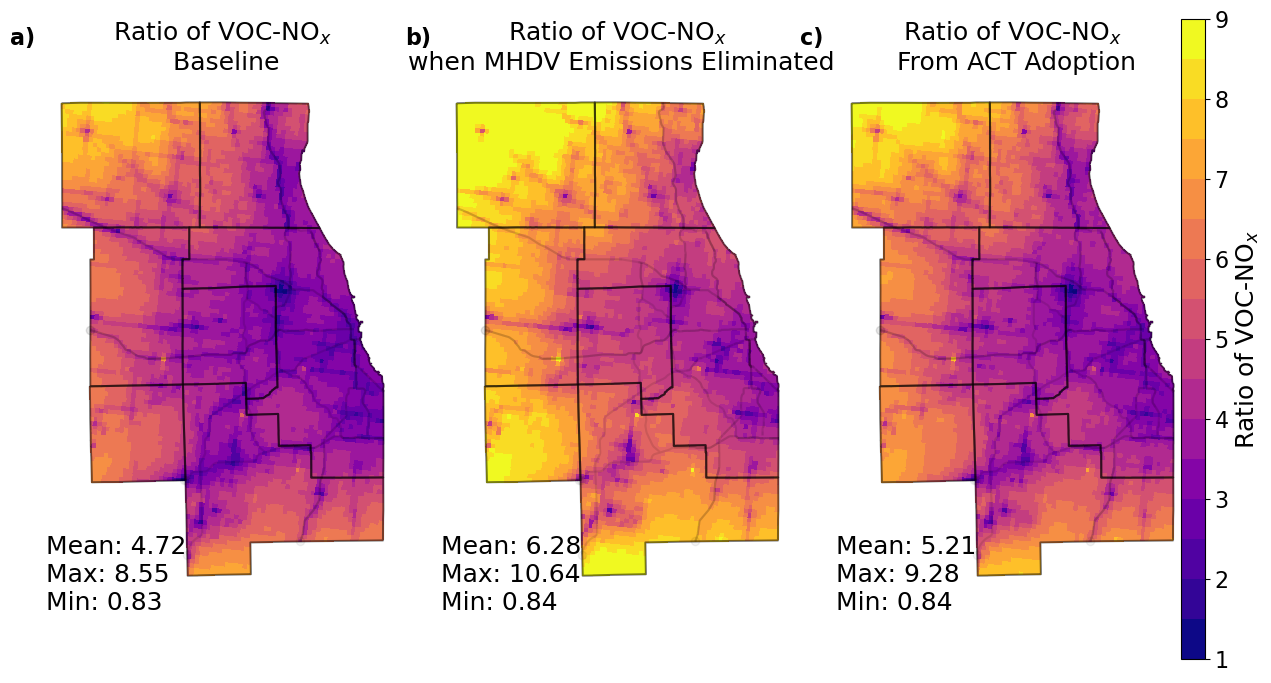

In [15]:
# Calculate the ratio of VOC to NOX
cmap_base['baseline_ratio'] = cmap_base['VOC'] / cmap_base['NOX']
cmap_act['act_ratio'] = cmap_act['VOC'] / cmap_act['NOX']
cmap_mhdv['mhdv_ratio'] = cmap_mhdv['VOC'] / cmap_mhdv['NOX']


# Calculate the ratio of VOC to NOX
cmap_base['baseline_ratio'] = cmap_base['VOC'] / cmap_base['NOX']
cmap_act['act_ratio'] = cmap_act['VOC'] / cmap_act['NOX']
cmap_mhdv['mhdv_ratio'] = cmap_mhdv['VOC'] / cmap_mhdv['NOX']

# Create subplots with 1 row and 3 columns, with larger figure size
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

# Create a discrete colormap based on plasma
plasma_colors = plt.cm.plasma(np.linspace(0, 1, 16))  # Get 16 evenly spaced colors from plasma colormap
cmap_discrete = ListedColormap(plasma_colors)

# Define the normalization and colorbar boundaries
vmin, vmax = 1, 9
bounds = np.linspace(vmin, vmax, cmap_discrete.N + 1)
norm = plt.Normalize(vmin, vmax)

# Plot cmap_base['VOC'] / cmap_base['NOX']
axs[0].set_title("Ratio of VOC-NO$_x$ \n Baseline", fontsize=18)
plot1 = cmap_base.plot('baseline_ratio', ax=axs[0], legend=False, vmin=vmin, vmax=vmax, cmap=cmap_discrete, antialiased=False)
cmap_cty.boundary.plot(ax=axs[0], color='k', alpha=.5)
cmap_roads.plot(ax=axs[0], color='k', alpha=.05)
axs[0].set_axis_off()
axs[0].text(-0.1, 1.1, "a)", transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top')
axs[0].text(0.001, -0.03, f"Mean: {cmap_base['baseline_ratio'].mean():.2f}\nMax: {cmap_base['baseline_ratio'].max():.2f}\nMin: {cmap_base['baseline_ratio'].min():.2f}",
            fontsize=18, transform=axs[0].transAxes, va='bottom', ha='left')

# Plot cmap_act['VOC'] / cmap_act['NOX']
axs[2].set_title("Ratio of VOC-NO$_x$\n From ACT Adoption", fontsize=18)
plot2 = cmap_act.plot('act_ratio', ax=axs[2], legend=False, vmin=vmin, vmax=vmax, cmap=cmap_discrete, antialiased=False)
cmap_cty.boundary.plot(ax=axs[2], color='k', alpha=.5)
cmap_roads.plot(ax=axs[2], color='k', alpha=.05)
axs[2].set_axis_off()
axs[2].text(-0.1, 1.1, "c)", transform=axs[2].transAxes, fontsize=16, fontweight='bold', va='top')
axs[2].text(0.001, -0.03, f"Mean: {cmap_act['act_ratio'].mean():.2f}\nMax: {cmap_act['act_ratio'].max():.2f}\nMin: {cmap_act['act_ratio'].min():.2f}",
            fontsize=18, transform=axs[2].transAxes, va='bottom', ha='left')

# Plot cmap_mhdv['VOC'] / cmap_mhdv['NOX']
axs[1].set_title("Ratio of VOC-NO$_x$\n when MHDV Emissions Eliminated", fontsize=18)
plot3 = cmap_mhdv.plot('mhdv_ratio', ax=axs[1], legend=False, vmin=vmin, vmax=vmax, cmap=cmap_discrete, antialiased=False)
cmap_cty.boundary.plot(ax=axs[1], color='k', alpha=.5)
cmap_roads.plot(ax=axs[1], color='k', alpha=.05)
axs[1].set_axis_off()
axs[1].text(-0.1, 1.1, "b)", transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1].text(0.001, -0.03, f"Mean: {cmap_mhdv['mhdv_ratio'].mean():.2f}\nMax: {cmap_mhdv['mhdv_ratio'].max():.2f}\nMin: {cmap_mhdv['mhdv_ratio'].min():.2f}",
            fontsize=18, transform=axs[1].transAxes, va='bottom', ha='left')

# Adjust layout to shift the colorbar to the right
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.98, 0.1, 0.02, 0.8])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap_discrete), cax=cbar_ax)
cbar.set_label('Ratio of VOC-NO$_x$', fontsize=18)
cbar.ax.tick_params(labelsize=16)  # Set colorbar tick label size

plt.tight_layout()
plt.savefig('ACT_VOC_NOx.tiff', dpi=300, format='tiff')
plt.show()


<h1> PM2.5 Analysis (Not included in paper)

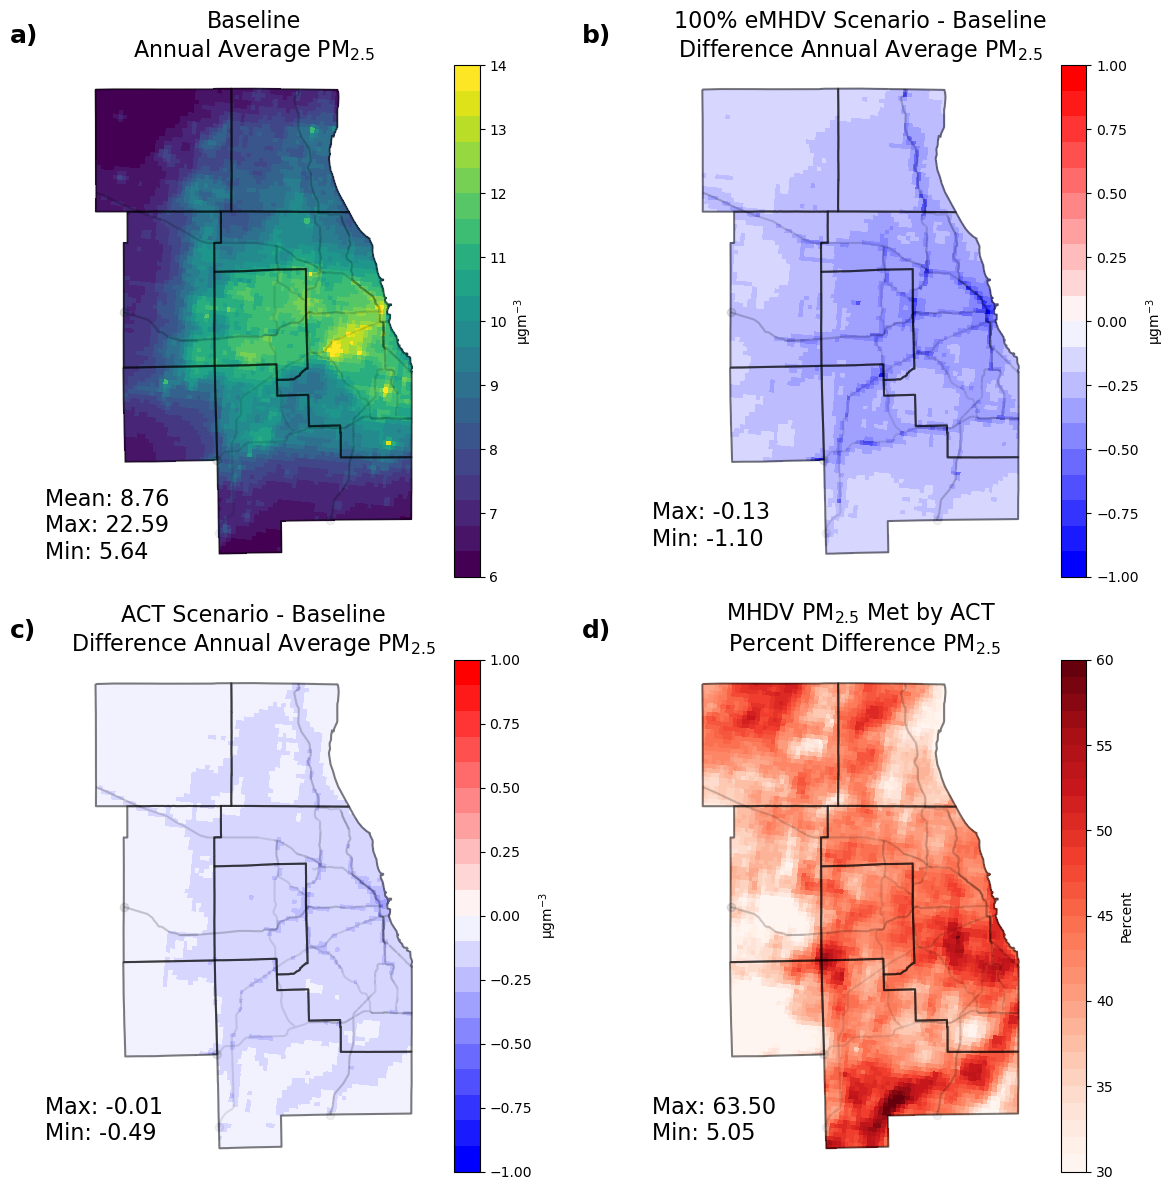

In [16]:
cmap_base['PM25_TOT_act_diff'] =  (cmap_act['PM25_TOT']-cmap_base['PM25_TOT'])
cmap_base['PM25_TOT_mhdv_diff'] =  (cmap_mhdv['PM25_TOT']-cmap_base['PM25_TOT'])

# Calculate the % difference between cmap_act and cmap_mhdv PM25_TOT
cmap_base['PM25_TOT_act_mhdv_diff'] = ((cmap_act['PM25_TOT'] - cmap_base['PM25_TOT']) / (cmap_mhdv['PM25_TOT'] - cmap_base['PM25_TOT'])) * 100
#cmap_base['PM25_TOT_act_mhdv_diff'] = ((cmap_base['PM25_TOT'] - cmap_act['PM25_TOT']) / (cmap_base['PM25_TOT'] - cmap_mhdv['PM25_TOT'])) * 100

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.viridis(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# First Figure (Panel a)
axs[0, 0].set_title("Baseline\nAnnual Average PM$_{{2.5}}$", fontsize=16)
cmap_base.plot('PM25_TOT', ax=axs[0, 0],vmin=6, vmax=14, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "µgm$^{-3}$", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[0, 0], color='k', alpha=.5)
cmap_roads.plot(ax=axs[0, 0], color='k', alpha=.05)
axs[0, 0].set_axis_off()
axs[0, 0].text(-0.2, 1.08, "a)", transform=axs[0, 0].transAxes, fontsize=18, fontweight='bold', va='top')
axs[0, 0].text(-0.1, 0.1, f"Mean: {cmap_base['PM25_TOT'].mean():.2f}\nMax: {cmap_base['PM25_TOT'].max():.2f}\nMin: {cmap_base['PM25_TOT'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[0, 0].transAxes)

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.bwr(np.linspace(0, 1, 20))  # Get 20 evenly spaced colors from Viridis colormap
cmap_discrete = ListedColormap(viridis_colors)

# Second Figure (Panel b)
axs[0, 1].set_title("100% eMHDV Scenario - Baseline\nDifference Annual Average PM$_{{2.5}}$", fontsize=16)
cmap_base.plot('PM25_TOT_mhdv_diff', ax=axs[0, 1], vmin=-1, vmax=1, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "µgm$^{-3}$", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[0, 1], color='k', alpha=.5)
cmap_roads.plot(ax=axs[0, 1], color='k', alpha=.05)
axs[0, 1].set_axis_off()
axs[0, 1].text(-0.3, 1.08, "b)", transform=axs[0, 1].transAxes, fontsize=18, fontweight='bold', va='top')
axs[0, 1].text(-0.1, 0.1, f"Max: {cmap_base['PM25_TOT_mhdv_diff'].max():.2f}\nMin: {cmap_base['PM25_TOT_mhdv_diff'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[0, 1].transAxes)

# Third Figure (Panel c)
axs[1, 0].set_title("ACT Scenario - Baseline\nDifference Annual Average PM$_{{2.5}}$", fontsize=16)
cmap_base.plot('PM25_TOT_act_diff', ax=axs[1, 0], vmin=-1, vmax=1, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "µgm$^{-3}$", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[1, 0], color='k', alpha=.5)
cmap_roads.plot(ax=axs[1, 0], color='k', alpha=.05)
axs[1, 0].set_axis_off()
axs[1, 0].text(-0.2, 1.08, "c)", transform=axs[1, 0].transAxes, fontsize=18, fontweight='bold', va='top')
axs[1, 0].text(-0.1, 0.1, f"Max: {cmap_base['PM25_TOT_act_diff'].max():.2f}\nMin: {cmap_base['PM25_TOT_act_diff'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[1, 0].transAxes)

# Create a discrete colormap based on Viridis
viridis_colors = plt.cm.Reds(np.linspace(0, 1, 30))  # Get 100 evenly spaced colors from reds colormap
cmap_discrete = ListedColormap(viridis_colors)

# Fourth Figure (Panel d)
axs[1, 1].set_title("MHDV PM$_{{2.5}}$ Met by ACT\n Percent Difference PM$_{{2.5}}$", fontsize=16)
cmap_base.plot('PM25_TOT_act_mhdv_diff', ax=axs[1, 1], vmin=30, vmax=60, legend=True, cmap=cmap_discrete, antialiased=False,
               legend_kwds={"label": "Percent", "orientation":"vertical"})
cmap_cty.boundary.plot(ax=axs[1, 1], color='k', alpha=.5)
cmap_roads.plot(ax=axs[1, 1], color='k', alpha=.05)
axs[1, 1].set_axis_off()
axs[1, 1].text(-0.3, 1.08, "d)", transform=axs[1, 1].transAxes, fontsize=18, fontweight='bold', va='top')
axs[1, 1].text(-0.1, 0.1, f"Max: {cmap_base['PM25_TOT_act_mhdv_diff'].max():.2f}\nMin: {cmap_base['PM25_TOT_act_mhdv_diff'].min():.2f}",
               horizontalalignment='left', fontsize=16, verticalalignment='center', transform=axs[1, 1].transAxes)

plt.tight_layout()
plt.savefig('PM25_TOT_ACT.tiff')
plt.show()